In [ ]:
import s3fs
import xarray as xr
import zarr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import datetime
import matplotlib.pyplot as plt

start_date = datetime.datetime(2025, 12, 5, 0, 0, 0)
nHrs = 24

In [ ]:
projection = ccrs.LambertConformal(central_longitude=262.5, 
                                   central_latitude=38.5, 
                                   standard_parallels=(38.5, 38.5),
                                    globe=ccrs.Globe(semimajor_axis=6371229,
                                                     semiminor_axis=6371229))
def load_dataset(urls):
    fs = s3fs.S3FileSystem(anon=True)
    ds = xr.open_mfdataset([s3fs.S3Map(url, s3=fs) for url in urls], engine='zarr', decode_timedelta=False)
    ds = ds.rename(projection_x_coordinate='x', projection_y_coordinate='y')
    ds = ds.metpy.assign_crs(projection.to_cf())
    ds = ds.metpy.assign_latitude_longitude()
    ds = ds.set_coords('time')
    return ds

In [ ]:
def load_combined_dataset(start_date, num_hours, level, param_short_name):
    combined_ds = None
    for i in range(num_hours):
        time = start_date + datetime.timedelta(hours=i)
        group_url = time.strftime(f's3://hrrrzarr/sfc/%Y%m%d/%Y%m%d_%Hz_fcst.zarr/{level}/{param_short_name}')
        subgroup_url = f'{group_url}/{level}'
        partial_ds = load_dataset([group_url, subgroup_url])
        if not combined_ds:
            combined_ds = partial_ds
        else:
            combined_ds = xr.concat([combined_ds, partial_ds], dim='time', combine_attrs='drop_conflicts')
    return combined_ds

In [ ]:
ds_prcp = load_combined_dataset(start_date, nHrs, 'surface', 'PRATE')


In [ ]:
ds_prcp

<xarray.Dataset> Size: 4GB
Dimensions:                  (time: 552, y: 1059, x: 1799)
Coordinates:
  * x                        (x) float64 14kB -2.698e+06 ... 2.696e+06
  * y                        (y) float64 8kB -1.587e+06 -1.584e+06 ... 1.587e+06
  * time                     (time) datetime64[ns] 4kB 2025-12-05T01:00:00 .....
    metpy_crs                object 8B Projection: lambert_conformal_conic
    latitude                 (y, x) float64 15MB 21.14 21.15 ... 47.85 47.84
    longitude                (y, x) float64 15MB -122.7 -122.7 ... -60.95 -60.92
Data variables:
    forecast_period          (time) int64 4kB dask.array<chunksize=(48,), meta=np.ndarray>
    forecast_reference_time  (time) datetime64[ns] 4kB 2025-12-05 ... 2025-12...
    PRATE                    (time, y, x) float32 4GB dask.array<chunksize=(48, 150, 150), meta=np.ndarray>

In [ ]:
ds_prcp_nw = ds_prcp.where(
    (ds_prcp.latitude >= 39) & (ds_prcp.latitude <= 50) &
    (ds_prcp.longitude >= -125) & (ds_prcp.longitude <= -110),
    drop=True
)
ds_prcp_nw

<xarray.Dataset> Size: 3GB
Dimensions:                  (time: 552, y: 485, x: 477)
Coordinates:
  * x                        (x) float64 4kB -2.341e+06 ... -9.125e+05
  * y                        (y) float64 4kB 1.317e+05 1.347e+05 ... 1.584e+06
  * time                     (time) datetime64[ns] 4kB 2025-12-05T01:00:00 .....
    metpy_crs                object 8B Projection: lambert_conformal_conic
    latitude                 (y, x) float64 2MB 36.62 36.63 ... 52.02 52.03
    longitude                (y, x) float64 2MB -124.1 -124.0 ... -110.5 -110.5
Data variables:
    forecast_period          (time, y, x) float64 1GB dask.array<chunksize=(48, 485, 477), meta=np.ndarray>
    forecast_reference_time  (time, y, x) datetime64[ns] 1GB NaT NaT ... NaT NaT
    PRATE                    (time, y, x) float32 511MB dask.array<chunksize=(48, 132, 149), meta=np.ndarray>

In [ ]:
tot_prcp = ds_prcp_nw.PRATE.sum(dim="time") * 3600  # convert from kg/m2/s to mm/hr
tot_prcp

<xarray.DataArray 'PRATE' (y: 485, x: 477)> Size: 925kB
dask.array<mul, shape=(485, 477), dtype=float32, chunksize=(132, 179), chunktype=numpy.ndarray>
Coordinates:
  * x          (x) float64 4kB -2.341e+06 -2.338e+06 ... -9.155e+05 -9.125e+05
  * y          (y) float64 4kB 1.317e+05 1.347e+05 ... 1.581e+06 1.584e+06
    metpy_crs  object 8B Projection: lambert_conformal_conic
    latitude   (y, x) float64 2MB 36.62 36.63 36.64 36.65 ... 52.02 52.02 52.03
    longitude  (y, x) float64 2MB -124.1 -124.0 -124.0 ... -110.6 -110.5 -110.5

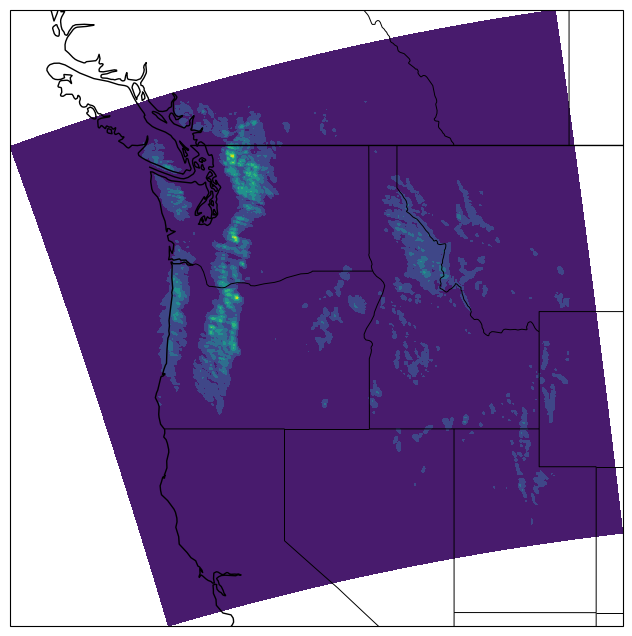

In [ ]:
# Add state lines (Natural Earth admin_1)
states = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none'
)

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': ccrs.Mercator()})
ax.contourf(tot_prcp.x, tot_prcp.y, tot_prcp, transform=projection)
ax.add_feature(states, edgecolor='black', linewidth=0.7)
ax.add_feature(cfeature.BORDERS, linewidth=1.0)
ax.coastlines()

plt.show()